<a href="https://colab.research.google.com/github/goldenspring6622/CS114.M21.N02/blob/main/Toxic_Comment_Detection_On_Youtube_Football_Livestream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install openpyxl


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### IMPORT PACKAGES

In [ ]:
!pip install chat_downloader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 80 kB 4.1 MB/s 
     |████████████████████████████████| 41 kB 462 kB/s 
     |████████████████████████████████| 54 kB 2.4 MB/s 


In [ ]:
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip3 install  xlrd==1.2.0
!pip install --upgrade pandas
!pip install underthesea
import os
import pandas as pd
import tensorflow as tf
import numpy as np
import time
from pandas import Series, DataFrame
import xlrd
from sklearn.feature_extraction.text import TfidfVectorizer
from xlrd import open_workbook
from underthesea import word_tokenize #https://pypi.org/project/underthesea/ anhv.ict91@gmail.com

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
dataTrainUIT = open_workbook("/content/Dataset.xlsx", encoding_override='latin')
df = pd.read_excel(dataTrainUIT)


In [ ]:
df.head()

,Content,Final
0,cặc,1
1,da kieu gi may dua,0
2,cố lên vn,0
3,cl mệ nó,1
4,Việt Nam ăn chắc rồi🇻🇳🇻🇳🇻🇳🇻🇳🇻🇳,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Count of Toxic Comment of Dataset')

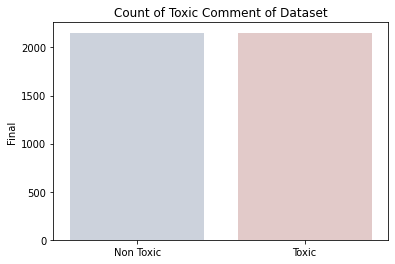

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(['Non Toxic', 'Toxic'], df['Final'].map({0:"Non Toxic", 1: "Toxic"}).value_counts(ascending=True), alpha=0.8,palette="vlag")

plt.title('Count of Toxic Comment of Dataset')

# 0. Crawl Data Go Bruh Bruh

In [ ]:
#Import package
import chat_downloader #Thank xenova for creating this fookin vjppr0 lib
from chat_downloader import ChatDownloader
import os
import re
from openpyxl import Workbook #Now prepare a xlsx to write crawl data
wb = Workbook()
# grab the active worksheet
ws = wb.active
# Data can be assigned directly to cells
ws['A1'] = 'Content'
ws['A2'] = 'Final'
#Now copy and paste something like
url = 'https://www.youtube.com/watch?v=Ejzw6Htgj7c'#Only the football live stream which has chat replay
chat = ChatDownloader().get_chat(url=url,start_time=None,end_time=None)#Get chats from url
save_path='/content/Data.txt'
d = 0
lst = []
# Create a generator
for message in chat:
	"""Crawled chat should be like this
	{
    ...
    "message_id": "xxxxxxxxxx",
    "message": "actual message goes here",
    "message_type": "text_message",
    "timestamp": 1613761152565924,
    "time_in_seconds": 1234.56,
    "time_text": "20:34",
    "author": {
        "id": "UCxxxxxxxxxxxxxxxxxxxxxxx",
        "name": "username_of_sender",
        "images": [
            ...
        ],
        "badges": [
            ...
        ]
    },
    ...
}"""
	#In here we just get 7000 messages
	#if(d>7000):break
	if (len(message['message'])>1):# iterate over messages
		with open(save_path, 'a', encoding='utf-8') as outfile:
			str = message['message']#Just take message content
			import re
			a = re.findall(':.*?:', str)#We will remove all emote, which start and end with char ':'
			for sub in a:
				str = str.replace(sub, '')
			# Now we try to remove all the same message content by create a substring without space char and check if it existed, write to file
			st=str.replace(' ','')
			if (str!='' and lst.count(st)==0):
			   ws.append([str])
			   lst.append(st)
			   d = d + 1
wb.save("Dataset.xlsx")


# 1. Preprocess

In [ ]:
!pip list

Package                       Version
----------------------------- ------------------------------
absl-py                       1.1.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.2.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.4.0
audioread                     2.1.9
autograd                      1.4
Babel                         2.10.2
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        5.0.0
blis                          0.7.7
bokeh                         2.3.3
branca                        0.5.0
bs4                           0.0.1
CacheControl                  0.

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
X = df['Content']
y = df['Final']
WordSeg = []
for i in range(len(X)):
        sentence_strip = str(X[i]).strip()# Remove spaces at begin & end
        WordSeg.append(word_tokenize(sentence_strip, format='text')) # format text: add "_" where text is phrases.
X = pd.DataFrame(WordSeg) # Update new sentences
print(X)

                                                      0
0                                                   cặc
1                                    da kieu gi may dua
2                                             cố lên vn
3                                              cl mệ nó
4              Việt_Nam ăn_chắc rồi 🇻_🇳_🇻_🇳_🇻_🇳_🇻_🇳_🇻_🇳
...                                                 ...
4294                              đcm trọng_tài mua rồi
4295                                     chừng nào đá v
4296                                                Hòa
4297  TÀI NHƯ LỒN TÀI NHƯ LỒN TÀI NHƯ LỒN TÀI NHƯ LỒ...
4298                                       bố mấythg đơ

[4299 rows x 1 columns]


In [ ]:
MAX_FEATURES = 200000 # number of words in the vocab

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=50,
                               output_mode='int')

In [ ]:
vectorizer.adapt(X.values)

In [ ]:
vectorized_text = vectorizer(X.values)

In [ ]:
print(vectorized_text)

tf.Tensor(
[[ 204    0    0 ...    0    0    0]
 [ 134  852  508 ...    0    0    0]
 [  64   29    4 ...    0    0    0]
 ...
 [ 318    0    0 ...    0    0    0]
 [ 108   96  106 ...  106    0    0]
 [ 234 2938 1208 ...    0    0    0]], shape=(4299, 50), dtype=int64)


In [ ]:
print(vectorized_text)

tf.Tensor(
[[ 204    0    0 ...    0    0    0]
 [ 134  852  508 ...    0    0    0]
 [  64   29    4 ...    0    0    0]
 ...
 [ 318    0    0 ...    0    0    0]
 [ 108   96  106 ...  106    0    0]
 [ 234 2938 1208 ...    0    0    0]], shape=(4299, 50), dtype=int64)


In [ ]:
#MCSHBAP - map, chache, shuffle, batch, prefetch  from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
train = dataset.take(int(len(dataset)*.6))
val = dataset.skip(int(len(dataset)*.6)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.2))

# 2. Create Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import 
\

In [ ]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(512, activation='relu'))
# Final layer 
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 512)               131584    
                                                                 
 dense_3 (Dense)             (None, 1)                 513       
                                                        

In [ ]:
history = model.fit(train, epochs=15, validation_data=val)

Epoch 1/15
161/161 [==============================] - 37s 195ms/step - loss: 0.5380 - val_loss: 0.3064
Epoch 2/15
161/161 [==============================] - 19s 115ms/step - loss: 0.3047 - val_loss: 0.2227
Epoch 3/15
161/161 [==============================] - 18s 115ms/step - loss: 0.2102 - val_loss: 0.1259
Epoch 4/15
161/161 [==============================] - 18s 109ms/step - loss: 0.1546 - val_loss: 0.0823
Epoch 5/15
161/161 [==============================] - 20s 122ms/step - loss: 0.1033 - val_loss: 0.0775
Epoch 6/15
161/161 [==============================] - 19s 117ms/step - loss: 0.0886 - val_loss: 0.0802
Epoch 7/15
161/161 [==============================] - 19s 118ms/step - loss: 0.0826 - val_loss: 0.0627
Epoch 8/15
161/161 [==============================] - 18s 114ms/step - loss: 0.1381 - val_loss: 0.0517
Epoch 9/15
161/161 [==============================] - 20s 123ms/step - loss: 0.0708 - val_loss: 0.0539
Epoch 10/15
161/161 [==============================] - 21s 128ms/step - l

In [ ]:
from matplotlib import pyplot as plt

<Figure size 576x360 with 0 Axes>

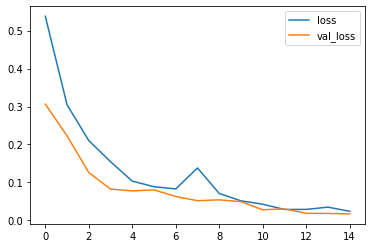

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [ ]:
input_text = vectorizer(['tụi m giỏi thì vào mà đá, ở đó mà sủa ngu'])

In [ ]:
print(input_text)

tf.Tensor(
[[178  37 203  19  23  12   2 206 131  12 362  24   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [ ]:
res = model.predict(input_text)

In [ ]:
print(res)

[[1.]]


In [ ]:
(res > 0.5).astype(int)

array([[1]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]])

In [ ]:
res.shape

(1, 1)

In [ ]:
input_text = vectorizer(['Việt Nam vô địch'])

In [ ]:
print(input_text)

tf.Tensor(
[[ 63  48 111 914   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [ ]:
res = model.predict(input_text)

In [ ]:
print(res)

[[0.00722533]]


In [ ]:
(res > 0.5).astype(int)

array([[0]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [1]])

In [ ]:
res.shape

(1, 1)

In [ ]:
input_text = vectorizer(['Việt Nam vô địt'])

In [ ]:
print(input_text)

tf.Tensor(
[[ 63  48 111 303   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [ ]:
res = model.predict(input_text)

In [ ]:
print(res)

[[0.9990566]]


In [ ]:
(res > 0.5).astype(int)

array([[1]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

array([[1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1]])

In [ ]:
res.shape

(1, 1)

In [ ]:
input_text = vectorizer(['chửi chết nó đi anh em'])

In [ ]:
print(input_text)

tf.Tensor(
[[170 116  11   8 120 185   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0]], shape=(1, 50), dtype=int64)


In [ ]:
res = model.predict(input_text)

In [ ]:
print(res)

[[0.9885401]]


In [ ]:
(res > 0.5).astype(int)

array([[1]])

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

array([[0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0]])

In [ ]:
res.shape

(1, 1)

# 4. Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    print(batch)
    X_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    print(y_true)
    yhat = yhat.flatten()
    print(yhat)
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

(array([[1067,   10,  496,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [3117, 1013,    2,    5,  632,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   2,   94,   14,  194, 1351,   11,    2,  539,  830,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  

In [ ]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.9954751133918762, Recall:0.9954751133918762, Accuracy:0.2075471729040146


In [ ]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    X_true, y_true = batch
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    print(yhat)
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

[4.2784741e-05 9.9808633e-01 2.8836439e-05 1.0000000e+00 2.9935241e-03
 1.0000000e+00 9.9491751e-01 9.9999958e-01 1.4155042e-09 4.1885304e-08
 4.9195274e-05 5.0364620e-06 4.9375126e-06 1.0206997e-03 9.9375308e-01
 9.9849588e-01]
[1.4409423e-04 9.9999583e-01 1.8039346e-04 9.9999726e-01 8.5955858e-04
 3.8467013e-05 9.9997264e-01 7.2659087e-01 9.9999356e-01 9.9999976e-01
 4.4743575e-07 2.4648839e-09 9.9996066e-01 3.2310221e-05 1.0000000e+00
 1.9368741e-08]
[9.9983996e-01 9.3194407e-01 5.5689252e-06 1.4976263e-03 1.1596894e-06
 1.2598248e-05 8.9880824e-04 7.3245168e-04 8.7836385e-04 9.9991220e-01
 9.7271693e-01 9.9999571e-01 1.2708978e-05 1.0000000e+00 7.8125140e-06
 9.9323857e-01]
[3.0700487e-06 8.3670209e-08 9.3400884e-01 2.0852085e-06 9.4176233e-01
 4.3723767e-07 9.5353734e-01 1.0000000e+00 5.8958653e-07 1.0000000e+00
 1.0000000e+00 1.0000000e+00 9.9999970e-01 1.7349050e-06 9.9999988e-01
 9.9997872e-01]
[9.9999964e-01 5.4122592e-07 1.2321935e-05 9.9998260e-01 9.9999940e-01
 9.9999642e-0